### Data Exploration 

Goal: explore the data, get a sense of what approaches or classifiers might be needed.

In [3]:
from __future__ import (absolute_import,
                        division)

import pandas as pd
from collections import Counter
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [4]:
# import modern magic cards from file 
modern = pd.read_pickle('data/5color_modern_no_name_hardmode.pkl')

modern.head(2)

,artist,cmc,colors,flavor,manaCost,name,power,rarity,text,toughness,type,types,set,releaseDate
0,Michael Sutfin,4,Black,To gaze under its hood is to invite death.,{2}{B}{B},Abyssal Specter,2,Uncommon,"Flying Whenever This deals damage to a player,...",3,Creature — Specter,[Creature],Eighth Edition,2003-07-28
1,Wayne England,5,Blue,Pray that it doesn't seek the safety of your l...,{3}{U}{U},Air Elemental,4,Uncommon,Flying,4,Creature — Elemental,[Creature],Eighth Edition,2003-07-28


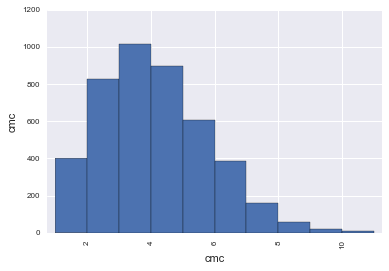

In [5]:
# drop nans and get a basic scatter matrix 

numvals = modern[['cmc', 'power', 'toughness']]
numvals = numvals[numvals['cmc'].notnull()]
numvals = numvals[numvals['power'].notnull()]
numvals = numvals[numvals['toughness'].notnull()]

pd.scatter_matrix(numvals);

In [6]:
# check class balance 

Counter(modern['colors'])

Counter({u'Black': 1576,
         u'Blue': 1573,
         u'Green': 1566,
         u'Red': 1575,
         u'White': 1584})

#### Classes are almost perfectly balanced. This is becuase I'm using an artifical dataset. 

In [7]:
def countwords(x):
    return len(x)

modern['word_count'] = modern['text'].apply(countwords)

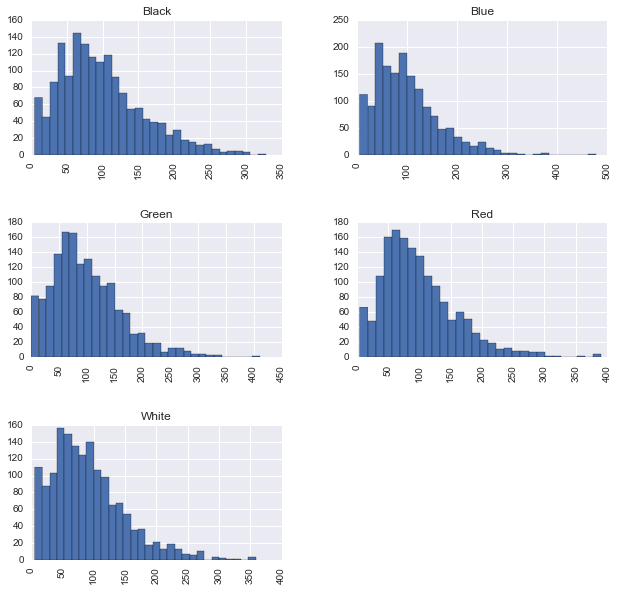

In [22]:
# word count by color 

modern.word_count.hist(by=modern.colors, figsize=(10,10), bins=30);

#### Long tails, lets check out what cards are out there

In [30]:
modern[modern['word_count'] >= 400][['name', 'colors', 'text']]

,name,colors,text
5012,Skinshifter,Green,"{1}: Choose one — • Until end of turn, This be..."
5867,"Jace, Architect of Thought",Blue,"+1: Until your next turn, whenever a creature ..."
6221,"Garruk, Caller of Beasts",Green,+1: Reveal the top five cards of your library....


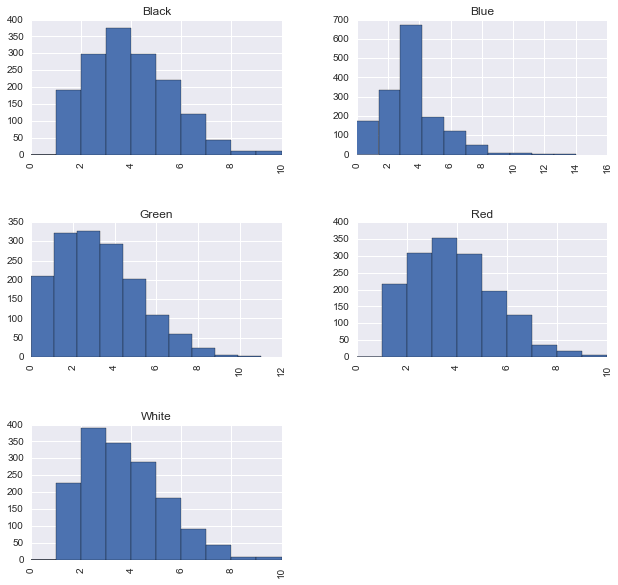

In [34]:
# resource cost by color 

modern.cmc.hist(by=modern.colors, figsize=(10,10), bins=10);

In [36]:
# highest resource cost cards

modern[modern['cmc'] >= 11][['name', 'colors', 'cmc']]

,name,colors,cmc
521,Blinkmoth Infusion,Blue,14
5937,Worldspine Wurm,Green,11
5974,Enter the Infinite,Blue,12
7219,Temporal Trespass,Blue,11


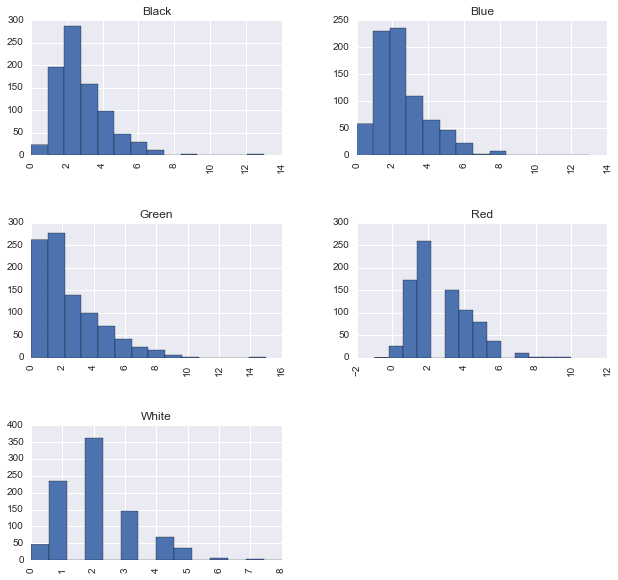

In [37]:
# slice to just creatures and display creature power by color 

modern2 = modern[modern['power'].notnull()]
modern2 = modern2[modern2['toughness'].notnull()]

modern2.power = pd.to_numeric(modern2.power, errors='coerce')

modern2.power.hist(by=modern2.colors, figsize=(10,10), bins=14)
plt.show();
    

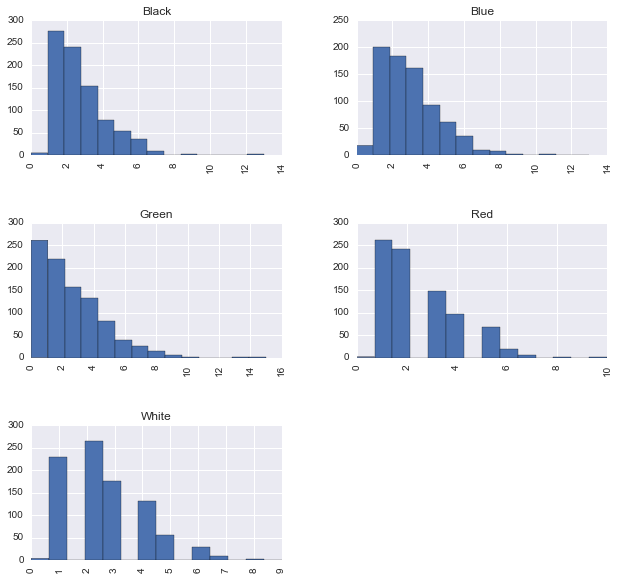

In [38]:
# creature toughness by color

modern2.toughness = pd.to_numeric(modern2.toughness, errors='coerce')

modern2.toughness.hist(by=modern2.colors, figsize=(10,10), bins=14)
plt.show();

In [39]:
# most common card descriptions 

freq = nltk.FreqDist(modern.text)
train_common = freq.most_common()
train_common[:10]

[(u'Flying', 57),
 (u'Reach ', 19),
 (u'Destroy target artifact or enchantment.', 15),
 (u'Haste ', 15),
 (u'Tap : Add {1} to your mana pool.', 13),
 (u'Target player discards two cards.', 13),
 (u'Draw two cards.', 12),
 (u'Swampwalk ', 12),
 (u'Flying ', 12),
 (u'Counter target spell.', 11)]

In [40]:
# vocab size

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=True)
vectorized_data = vectorizer.fit_transform(modern.text) 
vocab = len(vectorizer.vocabulary_)

print "There are %s unique words in the vocabulary." % vocab

There are 1161 unique words in the vocabulary.


### Top Words

In [41]:
# top 10 words 

def top_words(corpus, num, stop=None):
    vectorizer = CountVectorizer(stop_words=stop, lowercase=True)
    vectorized_data = vectorizer.fit_transform(corpus.text) 
    freqs = [(word, vectorized_data.getcol(idx).sum()) for word, idx 
             in vectorizer.vocabulary_.items()]
    words =  sorted (freqs, key = lambda x: -x[1])
    return [i[0] for i in words[:num]]

print "Top words from all cards"
top_words(modern, 10)

Top words from all cards


[u'this',
 u'creature',
 u'the',
 u'you',
 u'target',
 u'of',
 u'to',
 u'your',
 u'or',
 u'battlefield']

In [42]:
# top 10 words of each color 

def top_colors(sliced, num, stop=None):
    label = ["Black", "Blue", "Green", "Red", "White"]
    for l in label:
        print "Top %s words" % l
        print top_words(sliced.groupby('colors').get_group(l), num, stop)
        print 

top_colors(modern, 10)

Top Black words
[u'creature', u'this', u'the', u'target', u'you', u'of', u'your', u'card', u'to', u'player']

Top Blue words
[u'the', u'this', u'target', u'of', u'creature', u'you', u'or', u'card', u'your', u'to']

Top Green words
[u'creature', u'this', u'the', u'your', u'you', u'of', u'battlefield', u'target', u'put', u'to']

Top Red words
[u'this', u'creature', u'to', u'target', u'damage', u'of', u'the', u'deals', u'you', u'turn']

Top White words
[u'creature', u'this', u'you', u'the', u'target', u'battlefield', u'of', u'to', u'control', u'turn']



### With stop words removed 

In [43]:
print "Top words from all cards"
print top_words(modern, 10, stop='english')

Top words from all cards
[u'creature', u'target', u'battlefield', u'turn', u'control', u'card', u'end', u'player', u'damage', u'flying']


In [44]:
top_colors(modern, 10, stop='english')

Top Black words
[u'creature', u'target', u'card', u'player', u'life', u'battlefield', u'turn', u'end', u'cards', u'control']

Top Blue words
[u'target', u'creature', u'card', u'flying', u'cards', u'library', u'control', u'battlefield', u'hand', u'spell']

Top Green words
[u'creature', u'battlefield', u'target', u'control', u'turn', u'card', u'library', u'end', u'gets', u'enters']

Top Red words
[u'creature', u'target', u'damage', u'deals', u'turn', u'player', u'end', u'control', u'battlefield', u'creatures']

Top White words
[u'creature', u'target', u'battlefield', u'control', u'turn', u'flying', u'creatures', u'end', u'damage', u'enters']



In [45]:
# with formatting 

def top_colors(sliced, num, stop=None):
    label = ["Black", "Blue", "Green", "Red", "White"]
    df = pd.DataFrame(np.repeat(" ", (num * 5)).reshape((num, 5)), columns=label)
    for l in label:
        top = top_words(sliced.groupby('colors').get_group(l), num, stop)
        for n in xrange(num):
            df[l][n] = top[n]
    return df

top_colors(modern, 10, stop='english')

,Black,Blue,Green,Red,White
0,creature,target,creature,creature,creature
1,target,creature,battlefield,target,target
2,card,card,target,damage,battlefield
3,player,flying,control,deals,control
4,life,cards,turn,turn,turn
5,battlefield,library,card,player,flying
6,turn,control,library,end,creatures
7,end,battlefield,end,control,end
8,cards,hand,gets,battlefield,damage
9,control,spell,enters,creatures,enters
